# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

### Additional infos about the data
Additional infos from the corresponding video: 
- "This is simulated data for the sake of testing the algorithms. Not simulated data for the sake of mimiking real people."
- "Some people might respond negatively"
- "The goal is to discover what the best offer is in there [...] on an induvidual personalized level"

### What to do?

The ultimate goal is to generate business value. When sending adds there are multiple factors.
There are costs:
- Creating offers costs money. So an offer with zero response is lost effort
    - None of the offers have zero response. We can compare their effectiveness against eachother
- Deploying offers probably is not expensive so it is not worth considering.
    - however we could figure out when it´s best to deploy offers
- Giving out rewards costs money. How much exactly e.g. a BOGO offer really costs the company only can be guessed since giving rewards of x$ sale value does cost the company less than x$. So we would have to make assumptions there. 
    - we could try to identify how much an offer increases spending. Therefore however we would need two groups. 
and there are benefits
- Offers increase customer spending and therefore revenue

->
- classify if offer gets accepted
- classify if negative effect - we need some kind of controll group. search for it
  - we could try to identify demographic groups with similar behaviour but left out offers

## What we will do
- explore the data and see what we actually CAN da
- create a ML model that can predict if the offer gets accepted or not
- depending on the data another we can use SVD. 
    - There we could split the time data in half and predict the user reactions based on their an others previous behaviour
    - use the already implemented model to deal with the cold start problem
    - Then we can compare the aproaches
- figure out a way to get information about when not to send offers
- the ultimative goal would be a model that figures out by how much an offer in or decreases spending

## expectation
- high income do not react as well on adds as lower income
- older demographics won´t react as well.
- there will be a lot of inactive users who do not react at all



# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [2]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Explore and clean data

In [3]:
portfolio.head(15)
# we do have 3 different offer types. 
# - BOGO means By One Get One Free which is also why reward and difficulty match
# - informational only seems to be advertisement since there is no reward
# - discount is selfexplanatory. There however the difficulty VS reward seems a lot higher than BOGO

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
# now the cleaning process ... 
# create index containing type so we do not have to deal with hashes
portfolio.sort_values(['offer_type', 'reward', 'difficulty'], inplace=True)
offer_short_name = []
offer_type_counts = {}
for offer_type in portfolio.offer_type:
    offer_type = offer_type[0:4]
    offer_count = 0
    if not offer_type in offer_type_counts:
        offer_type_counts[offer_type] = 0
    else:
        offer_type_counts[offer_type] +=1
    offer_short_name.append(offer_type + str(offer_type_counts[offer_type]))
offer_short_name
portfolio['offer_short_name'] = offer_short_name

In [5]:
# as a final step let´s get the dummy variables
portfolio = portfolio.join(pd.get_dummies(portfolio.offer_type, dtype=np.int16))
portfolio = portfolio.join(pd.get_dummies(portfolio.channels.explode(), dtype=np.int16).sum(level=0))
portfolio.drop(columns = ['channels', 'offer_type'], inplace = True)

In [6]:
portfolio.head(15)

,reward,difficulty,duration,id,offer_short_name,bogo,discount,informational,email,mobile,social,web
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo0,1,0,0,1,1,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo1,1,0,0,1,1,1,1
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo2,1,0,0,1,1,1,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo3,1,0,0,1,1,1,1
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,disc0,0,1,0,1,1,1,1
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,disc1,0,1,0,1,1,0,1
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,disc2,0,1,0,1,1,1,1
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,disc3,0,1,0,1,0,0,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,info0,0,0,1,1,1,0,1
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,info1,0,0,1,1,1,1,0


In [7]:
# let´s have a look at the user profiles
profile.head(15)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


In [8]:
# We can see that there missing gender age and income 
# 118 seems to be the default value for a missing age
profile.age.replace(118, np.NAN, inplace=True)
# let´s drop all data that has zero information about a customer. We do want to make predictions about
# populations. Having zero information about a customer should result in little benefit.
# Losing 12% of entries also is not substantial. In a later iteration one could make another decision and
# train on the "no data" case as a special case.
mask_no_data = profile.gender.isnull() & profile.age.isnull() & profile.income.isnull()
print("Amount of dropped data: " + str(profile[mask_no_data].shape[0]/profile.shape[0]*100) + "%")
profile.drop(profile[mask_no_data].index,inplace=True)
profile[profile.gender.isnull()].shape[0], \
    profile[profile.age.isnull()].shape[0], \
        profile[profile.income.isnull()].shape[0]
# There were only entries missing all entires. No entry with single entries so no further decisions.

Amount of dropped data: 12.794117647058822%


(0, 0, 0)

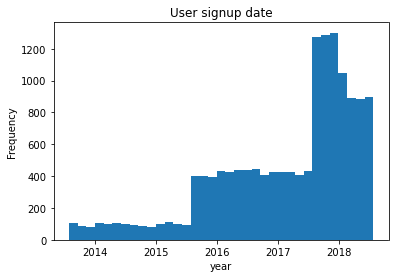

In [9]:
profile.became_member_on = pd.to_datetime(profile.became_member_on,format='%Y%m%d')
plt.hist(profile.became_member_on, bins = 35);
plt.title("User signup date");
plt.xlabel("year");
plt.ylabel("Frequency");
# it seems like there are four major groups of memebers. 
# - The ones that joind before mid of 2015
# - The big group that got joined starting mid of 2015. This most likely is related 
#   to the introduciton of Mobile Order & Pay expanded in June 2015. 
#   See https://stories.starbucks.com/stories/2015/year-in-review-2015-starbucks-innovations/
# - The even bigger group that started joining end of 2017
# - the other big group that joined in 2018 (here it is debatable though if they stil belog to the previous group)
# this indicates some major add campaign was going on during these events these years
# So it could be possible that at least the user profiles could be sampled from real data and not simulated

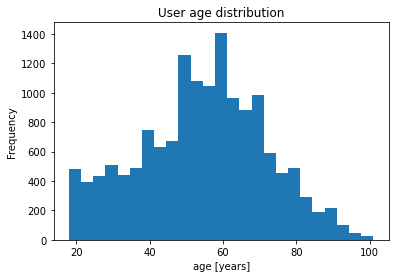

In [10]:
plt.hist(profile.age, bins = 25);

plt.title("User age distribution");
plt.xlabel("age [years]");
plt.ylabel("Frequency");
# the age distribution looks surprising. I would have expected a lot younger customer base esp.
# since this data is from a mobile app

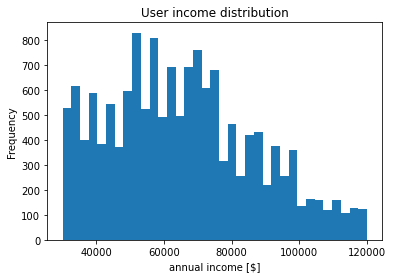

In [11]:
plt.hist(profile.income, bins = 35);

plt.title("User income distribution");
plt.xlabel("annual income [$]");
plt.ylabel("Frequency");
# income looks reasonable and is kind of comparable to the average US household 
# income distribution http://theglitteringeye.com/u-s-income-distributiona-chart-to-contemplate/ . 
# However the expected highvalue at the max position of 120k is missing. It also seems that in average
# the more wealthy households go to Starbucks

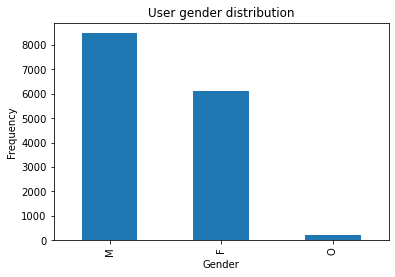

In [12]:
profile.gender.value_counts().plot(kind = 'bar');
plt.title("User gender distribution");
plt.xlabel("Gender");
plt.ylabel("Frequency");

# also looks reasonable. interesting though that there there are more male than female customers

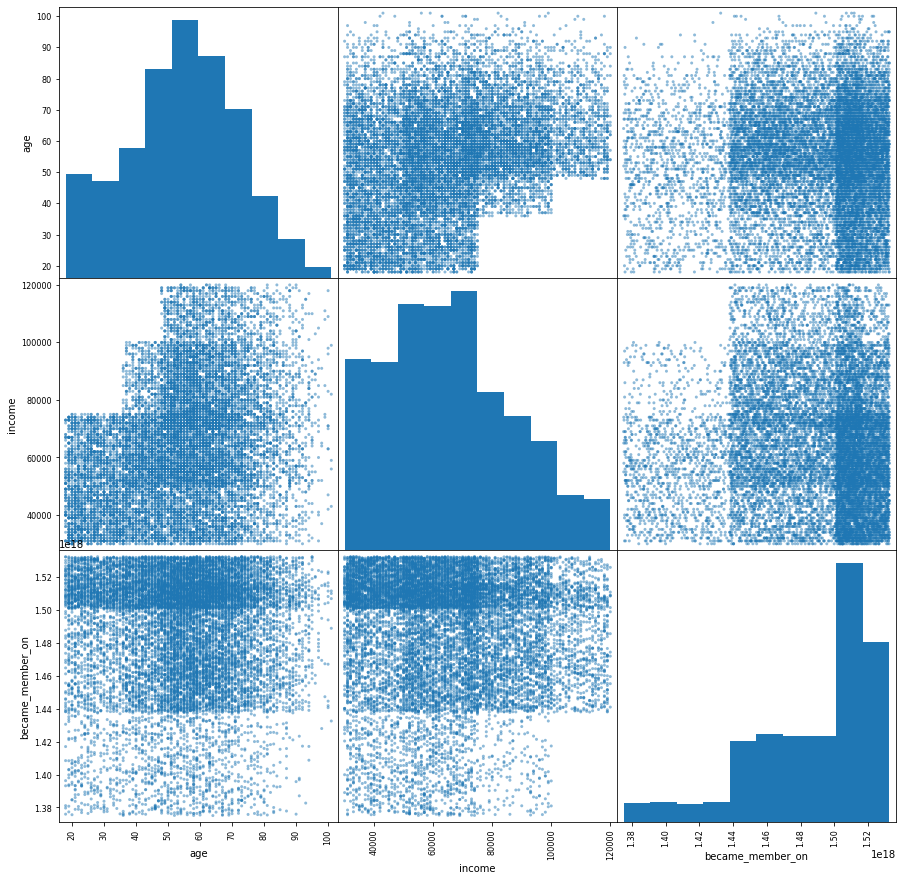

In [13]:
# so now we can look at things combined everything:
profile_plt = profile.copy()
# unfortunatly pd scatter does not work for datetime so we do have deal with ints
profile_plt.became_member_on = profile_plt.became_member_on.astype(np.int64)
pd.plotting.scatter_matrix(profile_plt[['age','income', 'became_member_on']], figsize=(15,15));


interesting things to see are that
- there seems like an artificial limit for income. There is no customer till the age of 35 that makes more than 80k$ and noone below 50 years who makes more than 100k$.
- before mid of 2015 the max income you could enter at the signup process seems to be 100k because noone that signed up before has a higher number
We have to keep in mind that this is simulated data. Since this is simulated data weird effects also might come from the simulation

In [14]:
transcript.head(15)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [15]:
# Let´s clean the event data
# so we have data of all costomers that are related to interactions. That´s good :)
profile.id.isin(transcript.person).mean()
transcript.person.isin(profile.id).mean() 
# now we get rid of the events that concern customers we have no profile data
mask_no_data = ~transcript.person.isin(profile.id)
print("Amount of dropped data: " + str(transcript[mask_no_data].shape[0]/transcript.shape[0]*100) + "%")
transcript.drop(transcript[mask_no_data].index,inplace=True)

Amount of dropped data: 11.017374907840566%


In [16]:
transcript = pd.concat([transcript.drop(['value'], axis=1), transcript.value.apply(pd.Series)], axis=1)
# we get rid of the dict and clean up the duplicated offer_id entry
transcript.offer_id.fillna(transcript['offer id'], inplace=True)
transcript.drop(columns=['offer id'],inplace=True)
# and create dummy variables for the event
transcript = transcript.join(pd.get_dummies(transcript.event, dtype=np.int16))
transcript.rename(columns={'offer completed': 'offer_completed', \
    'offer received' : 'offer_received', 'offer viewed' : 'offer_viewed'}, inplace=True)

In [17]:
# now we can combine everything: 
profile.rename(columns={'id': 'person'}, inplace=True)
transcript = transcript.merge(profile, how='left', on='person')
portfolio.rename(columns={'id': 'offer_id', 'reward' : 'offer_reward'}, inplace=True)
transcript = transcript.merge(portfolio, how='left', on='offer_id')
rewards = transcript.query("event == 'offer completed'")[['reward','offer_reward']]

np.sum(rewards.reward != rewards.offer_reward)
# reward and offer reward match so we can drop the event reward
transcript.drop(columns=['reward'],inplace=True)

In [18]:
transcript.head()

,person,event,time,amount,offer_id,offer_completed,offer_received,offer_viewed,transaction,gender,...,difficulty,duration,offer_short_name,bogo,discount,informational,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,F,...,5.0,7.0,bogo0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,0,1,0,0,M,...,10.0,7.0,disc1,0.0,1.0,0.0,1.0,1.0,0.0,1.0
2,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0,M,...,5.0,5.0,bogo1,1.0,0.0,0.0,1.0,1.0,1.0,1.0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,NaN,3f207df678b143eea3cee63160fa8bed,0,1,0,0,M,...,0.0,4.0,info0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0,F,...,20.0,10.0,disc3,0.0,1.0,0.0,1.0,0.0,0.0,1.0


14825

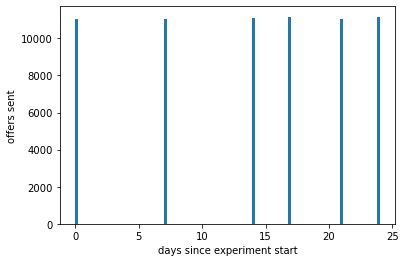

In [19]:
# Let´s have a look at the recorded event data and try to understand the experiment
transcript.time.max()/24
# we do have roughly 30 days of event data. 30 days after signup for each customer? 30 days of events of all customers? 
# the assumption is that this is 30 continuous days of events since that makes most sense in terms of an experiment
plt.hist(transcript.query("event == 'offer received'").time/24,bins=100);

plt.xlabel("days since experiment start");
plt.ylabel("offers sent");
transcript.person.nunique()
# Within these 30 days at six different times offers get sent. The amount of offers sent each time roughly equals 
# the amount of users.

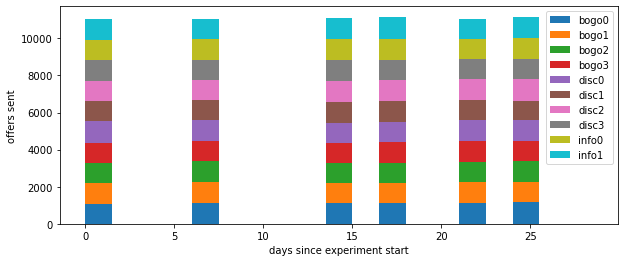

In [20]:
# let´s figure out if there is a systematic when which offer was sent
ids = portfolio.offer_id.dropna().unique()
offers_sent = transcript.query("event == 'offer received'")
bins = np.arange(0,30,1.5)
stacked_offers = []
offer_names = []
for id in ids:
    vals = offers_sent.query("offer_id == @id").time/24
    stacked_offers.append(vals)
    offer_names.append(offers_sent.query("offer_id == @id").offer_short_name.dropna().unique()[0])
plt.figure(figsize=(10, 4))
plt.hist(stacked_offers, bins=bins,histtype='bar', stacked=True);
# TODO: create legend
plt.legend(offer_names,loc='upper right');
plt.xlabel("days since experiment start");
plt.ylabel("offers sent");
# all different offer types are sent out each time in roughly equal amounts to the customers

In [21]:
offer_waves = (transcript.person.nunique() - transcript.query("event == 'offer received'").time.value_counts()\
    .sort_values())/transcript.person.nunique()*100
offer_waves2 = (transcript.person.nunique() - transcript.query("offer_received == 1").time.value_counts()\
    .sort_values())/transcript.person.nunique()*100
offer_waves
# about a quarter of users does get no offer each wave

0      25.645868
504    25.477234
168    25.389545
336    25.261383
408    24.964587
576    24.688027
Name: time, dtype: float64

C:\Users\patri\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,all offers,offers excluding informational
5,5173,2748.0
4,4362,4561.0
6,2663,675.0
3,2028,4164.0
2,532,2059.0
1,62,557.0
0,5,61.0


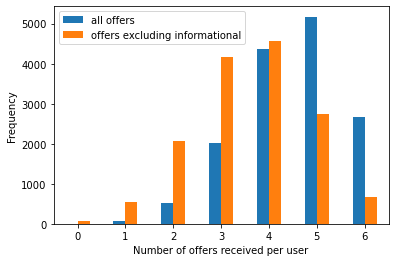

In [22]:
# we want to know if there is an easy control group that never get´s any offer
plot_df = pd.DataFrame()
plot_df['all offers'] = transcript.groupby(['person']).sum()['offer_received'].value_counts()
plot_df['offers excluding informational'] = \
    transcript.query("informational == 0").groupby(['person']).sum()['offer_received'].value_counts()
plot_df.fillna(0, inplace = True)
# add customers that we filtered out again
plot_df['offers excluding informational'].loc[0] += \
    transcript.person.drop_duplicates().isin(transcript.query("informational == 0").person).value_counts().loc[False]
plot_df.sort_index().plot.bar(rot=0)
plt.xlabel("Number of offers received per user")
plt.ylabel("Frequency")
plot_df.head(10)
# The number of customers receiving no offer matches the expectation given the 25% of users
# are sampled randomly
# Looks like there is at least no easy control group for the whole experiment
# an option would be to not count informational offers as real offers but also then there is no
# control group with a sufficient size.

,wave 1,wave 2,wave 3,wave 4,wave 5,wave 6
0,3802.0,952.0,251.0,65.0,18.0,5
1,11023.0,5662.0,2180.0,738.0,231.0,62
2,0.0,8211.0,6198.0,3201.0,1407.0,532
3,0.0,0.0,6196.0,6136.0,3918.0,2028
4,0.0,0.0,0.0,4685.0,5718.0,4362
5,0.0,0.0,0.0,0.0,3533.0,5173
6,0.0,0.0,0.0,0.0,0.0,2663


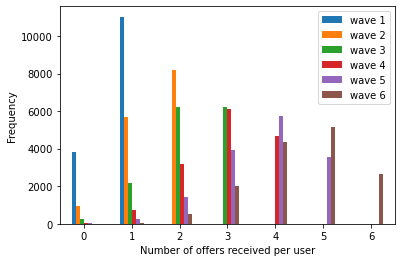

In [23]:
wave_times = np.sort(offer_waves.index)
received_offers = []
labels = []
plot_df = pd.DataFrame(index=range(7))
wave_id = 1
for time in wave_times:
    customer_per_time = transcript.query("time < (@time+1)").groupby(['person']).sum()
    wave_name = "wave " + str(wave_id)
    wave_id += 1
    plot_df[wave_name] = customer_per_time['offer_received'].value_counts()
    plot_df.fillna(0, inplace = True)
    try:
        plot_df[wave_name].loc[0] += \
            transcript.person.drop_duplicates().isin(customer_per_time.index).value_counts().loc[False]
    except:
        pass

plot_df.sort_index().plot.bar(rot=0)
plt.xlabel("Number of offers received per user")
plt.ylabel("Frequency")
plot_df.head(10)

In [24]:
# At least for the first wave we would have a big enough control group. one option would be to treat this first
# wave as an individual experiment and investigate this as an A/B test. Since there are 10 different offers tested at the same time
# each control group would around 400 data points.
# another option is the assumption in the data desciption:
# "for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the 
# offer for 7 days after receiving the advertisement."
# Since we are working with simulated data this is probably an asumption of the simulation as well. So we might not suffer from
# effects of previous offers treating the waves as individual experiments only with different historic data

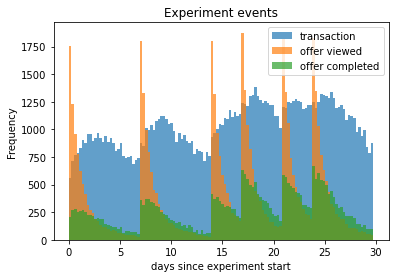

In [25]:
num_bins = 120
transparancy = 0.7
events = ['transaction', 'offer viewed', 'offer completed']
for event in events:
    (transcript.query("event == @event").time/24).plot.hist(bins=num_bins, alpha = transparancy, label = event);
plt.title("Experiment events");
plt.legend(loc='upper right');
plt.xlabel("days since experiment start");
# it looks like the offers have a positve impact on the number of transactions.

So we now do understand what happens:
 - all offers are sent in roughly equal amounts to customers in 6 waves
 - 25% of customers do not get an offer per wave
 - no user get´s the same offer twice
 - the assumption is that which offer is sent to which user is done by random sampling
this hypothesis could be confirmed investigating it´s statistical significance

In [26]:
# lets have a look how the individual waves impact the users. Wave one can be treated as an A/B test 

def get_events_by_wave(transcript):
    """
    Splits event data into the different offer waves

    Args:
        transcript (pd.Dataframe): df containing all event data

    Returns:
        list[pd.Dataframe]: list of data frames each containing one set of events
    """
    offer_wave_times = np.sort(transcript.query("event == 'offer received'").time.value_counts().index)
    data_during_waves = []
    transcript_copy = transcript.copy()
    transcript_copy.amount.fillna(0,inplace=True)
    for i_wave in range(6):
        start_time = offer_wave_times[i_wave] -1
        end_time = 10000
        if i_wave < 5:
            end_time = offer_wave_times[i_wave + 1] - 24
        data_during_waves.append(transcript.query("time > @start_time & time <@end_time"))
    return data_during_waves

def merge_events_to_user(transcript):
    """
    merges event data to the information we have about the user

    Args:
        transcript (pd.Dataframe): df containing all event data
    
    Returns:
        pd.Dataframe: df containing user attributes and event informations
    """

    wave_data = get_events_by_wave(transcript)
    user_event_data = pd.DataFrame()
    user_event_data['person'] = transcript.person.dropna().unique()
    for i_wave in range(6):
        wave = wave_data[i_wave]
        # let´s get the offers
        offer_type = wave.query("(event == 'offer received')")[['offer_short_name','person']]
        offer_type.rename(columns ={'offer_short_name' : 'w'+str(i_wave+1) +'_' + 'offer'},inplace = True)
        user_event_data = user_event_data.merge(offer_type, left_on='person', right_on='person',how='left').fillna('control')
        # let´s grab the summed data
        user_data = wave.groupby('person').sum()[['amount','transaction','offer_completed','offer_received','offer_viewed']]
        user_data.columns = 'w'+str(i_wave+1) +'_' + user_data.columns.values
        user_event_data = user_event_data.merge(user_data, left_on='person', right_on='person',how='left').fillna(0)
    return user_event_data
        
user_event_data = merge_events_to_user(transcript)

In [27]:
def plot_confidence_spending_change_by_offer(user_event_data, wave):
    """
    Plots effects of different offers on the mean user spending by comparing it to the control group that does
    not recieve any offer. For generating a confidence interval bootstrapping is used.

    Args:
        data_during_wave: dataframe containing user events during one offer wave
        all_user_ids: all ids. necessary because there might be persons without events in the event data
    """
    # null hypothesis H0: receiving offers does not increase the average spending
    # H1 is that it increases spending
    # we can use bootstrapping to get a confidence interval of this hypothesis. Lets do that for all types
    wave_prefix = 'w' + str(wave) + '_'
    field_name_transaction = wave_prefix + 'transaction'
    field_name_offer = wave_prefix + 'offer'
    offers = np.sort(user_event_data[wave_prefix+'offer'].unique())
    offers = np.delete(offers, np.argwhere(offers == 'control'))
    
    nrows=3
    ncols=4
    row = 0
    col = 0
    fig, axes = plt.subplots(nrows, ncols,figsize=(14,10))
    fig.tight_layout(h_pad=4, w_pad=4)
    fig.canvas.set_window_title('Influence of offer on spending')
    for offer in offers:
        diffs = []
        red_user_event_data = user_event_data[[field_name_offer,field_name_transaction]].copy()
        for _ in range(1000):
            bootsamp = red_user_event_data.sample(red_user_event_data.shape[0], replace = True)
            nooffer_mean = bootsamp.query(field_name_offer +" == 'control'")[field_name_transaction].mean()
            offer_mean = bootsamp.query(field_name_offer +" == @offer")[field_name_transaction].mean()
            diffs.append(offer_mean - nooffer_mean)
        
        plt.sca(axes[row,col])
        if col +1 >= ncols:
            col = 0
            row +=1
        else:
            col +=1
        
        plt.title(offer + " offer")
        diff_experiment = user_event_data.query(field_name_offer +" == @offer")[field_name_transaction].mean() - \
            user_event_data.query(field_name_offer +" == 'control'")[field_name_transaction].mean()
        plt.axvline(diff_experiment, color = 'black',label = "experiment");
        plt.hist(diffs,bins=40)
        ci_interval = 95
        # H1 is one tailed so we can cut off 5% for the 95% confidence interval
        plt.axvline(np.mean(diffs), color = 'grey',label = "mean");
        plt.axvline(np.percentile(diffs, 100 - ci_interval), color = 'red',label = str(ci_interval) + "% CI");
        plt.legend(loc='upper right');
        plt.xlabel("Mean increase in sales per user [$]")
        plt.ylabel("Frequency")
    axes[2,3].axis('off')
    axes[2,2].axis('off')

## How well are the different offers doing?

### Impact on revenue
Let´s have a look at increase in spending for the first offer wave:

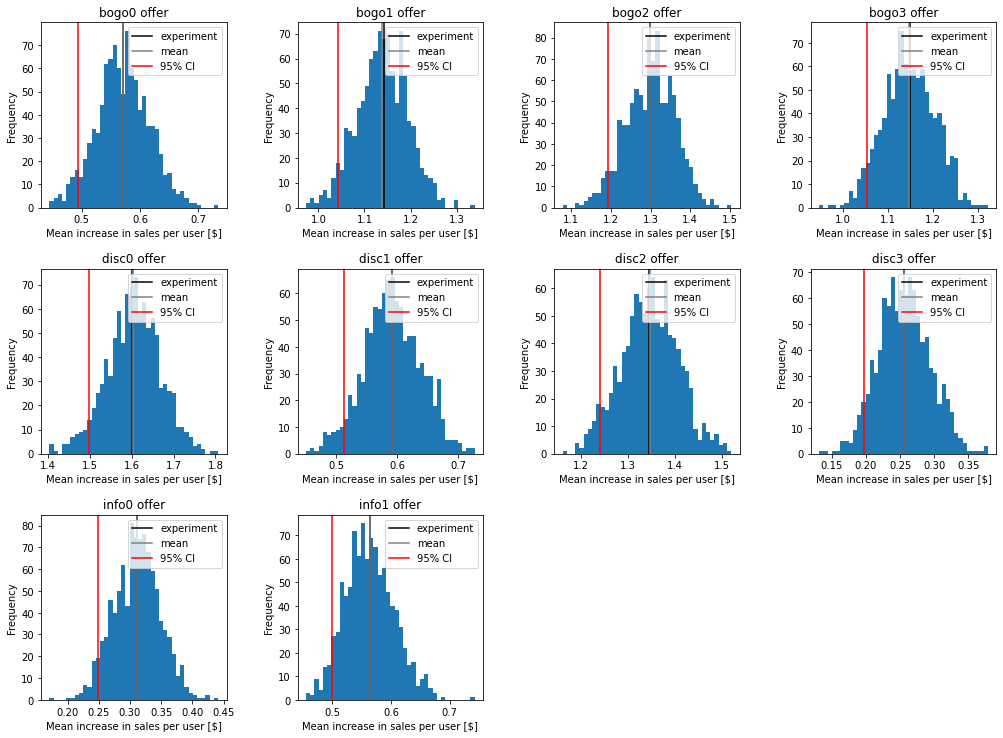

In [28]:
plot_confidence_spending_change_by_offer(user_event_data, 1)

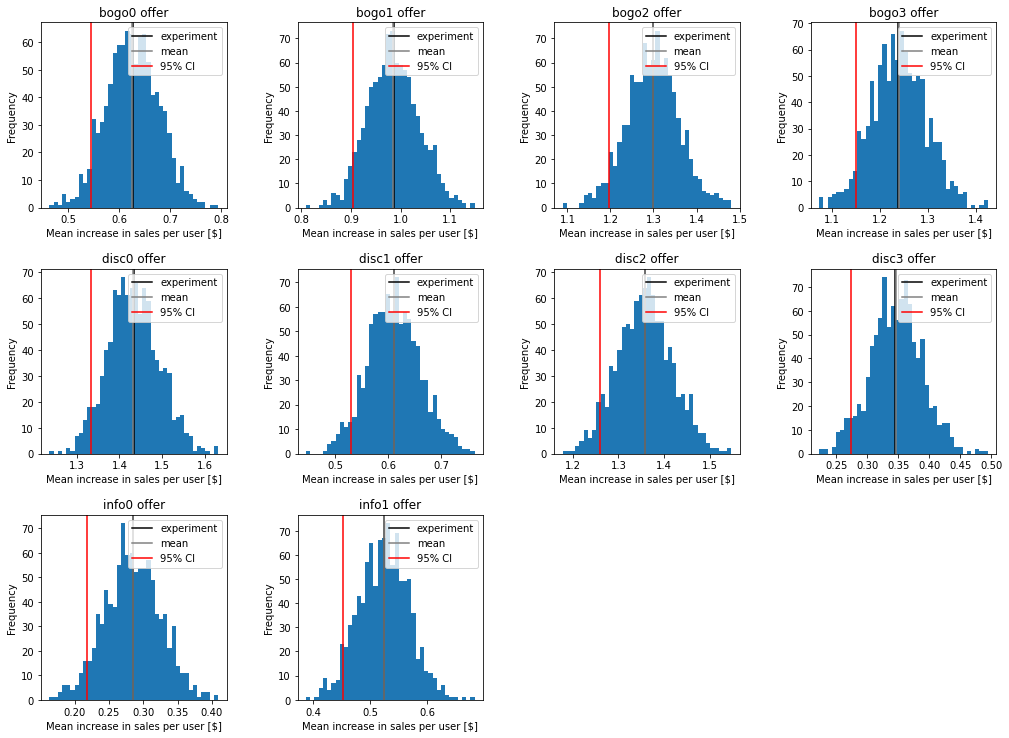

In [29]:
plot_confidence_spending_change_by_offer(user_event_data, 2)

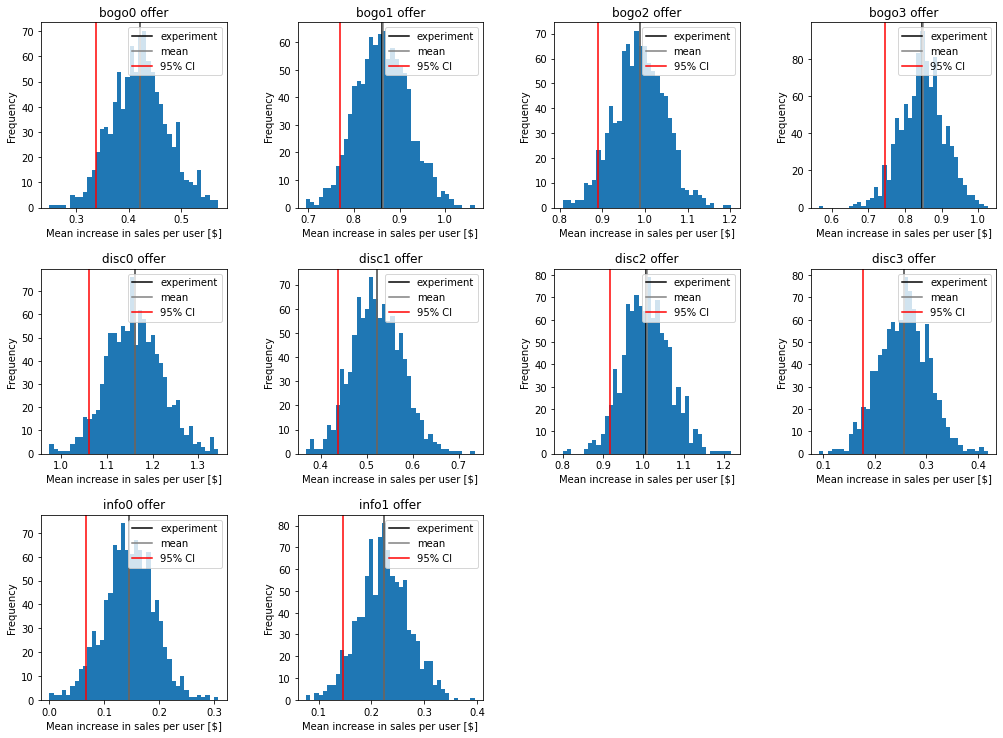

In [30]:
plot_confidence_spending_change_by_offer(user_event_data, 6)

every offer has a positive impact on the mean user revenue
General observations are
- the discount offer 0 & 2 increases revenue the most
- BOGO offers & discount offers are doing better than purely informational offers
- the impact of the offers in different waves is quite similar

However this is only looking at the increase in spending. The reward is not considered since there is no information  actually much a reward actually costs the company. For a BOGO offer with a reward of 5$ one would have to consider not 5$ but a lot less since the production cost is far less than the sale price. For a discount offer this is the same problem. Only for the informational offers we really can judge the impact on revenue. Which is positive :)

Going into more detail comparing different offers per type:

BOGO offers
- offer 0 & 1 do have the same difficulty and reward. However offer 1 is doing a lot better. The difference is that offer 0 is also distributed via social media. This seems to be an important factor
- Offer 2 & 3 also do have the same reward. Offer 2 is doing slightly better. The difference is that offer 2 is running two days longer and does not get distributed via web. This is a hint that an increase in offer time is beneficial. Two additioal days are more rewarding than the downside of not distributing via web.

Discount offers
- offer 0 and offer 1 do have the same reward and difficulty. Offer 1 does not get distributed via social media and has a decreased duration of 3 days. Offer 0 is doing far better than offer 1. This indicates that here as well social media is crucial for the success of an offer
- offer 0 and bogo offer 3 only differ in the kind of reward. The reward of the bogo offer is 5 times the amount of the discount. However the discount is doing a lot better. This indicates that people like discounts.
- offer 2 is a improved version of offer 0. The reward is increased by 1$ and the diffuculty decreased by 3$. The only downside is that the duration is decreased by 3 days. Surprisingly offer 2 is doing worse. So an increased reward and a decrease in difficutly surprisingly have less beneficial impact than an increase in duration
- offer 3 is doing worse. It has by far the highest difficulty of 20$ but at the same time also a higher reward of 5. It is only distributed by web and email. This confirums that not sending out the offer via mobile and social media really hurts

Informational offers
- offer 0 has a day longer duration and does not get distributed via social media. Offer 1 does not get distributed by web. Offer 1 is doing a lot better. This again is a hint for the high importance of distribution via social media.

We could gain more insights by comparing offers from different groups with eachother or the groups that actually viewed the offer. This unfortunatly is not in the time frame of this project.

What we learn:
- all offers increase revenue.
- we do not have the business understanding to decide what offer increases profit.
- distribution over the right channels is crucial for the success of your offer campaign. Do not forget social media and mobile.
- people like discounts more than BOGO. Even if the reward is not that high.

## Offer view rate and completion
Another measure to conclude how sucessful an offer is is the view and completion count of the different offers. Let´s have a look at them:

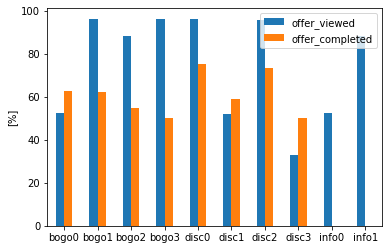

In [31]:
offer_data = transcript.groupby('offer_short_name').sum()
offer_data/offer_data.offer_received

(offer_data.div(offer_data.offer_received,axis = 0)*100)[['offer_viewed', 'offer_completed']].plot.bar(rot = 0);
plt.xlabel("");
plt.ylabel("[%]");

General observations 
- the amount of views is closely related to the way of distribution. There seems to be not a lot of relation to the actual offer itself. Offers being sent via all channels have a close to 100% view rate.
- missing out to sent the offer by web like for bogo2 and info1 only decreases the vew rate by around 5%.
- not sending out offers via social media hurt a lot. bogo0, disc1 and info0 have a lower than 55% view rate.
- bogo0, disc1 and disc 3 have a higher completion rate than vew rate. The amount of offers being completed but never viewed have to be quite high. By preventing this one could generate substantial business value since rewards are given out for no clear benefit. 

# What to do to increase business value?
We want to implement a recommendation engine that increases business value. Now there is the question what we are exactly going to do?

The best recommendation model would give out recommendations that directly increase/maximize company profit. For this we would have to send out the optimal offers regarding increase of profit per user. Unfortunatly we realized that we do not have enough business understanding and would have to work with a lot of assumptions. So the fallback option would be to recommend to maximize revenue. 
Creating labels for each person is difficult since we do have very little historic data. To see if we increase spending we would need more historic data for each user. Currently we could compare the period where an user is not under the influence of an offer to the one where the user get´s a specific offer. Since most of the users get four or more offers during the 6 offer waves that is expected to be very sparse data.

We also learned that the method of distribution and therefore getting the offer to the user is crucial for the sucess of an offer campaign as well. Creating a recommendation engine that recommends offers that are completed most likely is something that is a lot more feasible with the given data. Since we showed that all offers increase revenue this should have a positive impact on company profit.
Using this recommendation we also can generate business value by predicting the case where someone completes the offer without ever viewing it. As analyzed there is a significant cases where this is actually happening. This way we can prevent giving out rewards without receiving a benefit since the transaction most likely would have happened anyways. The scope of this project is limited we will now focuse on this

## Recommendation engine
We decided on creating a recommendation engine that recommends offers to users with the goal to maximize the offer completion. And at the same time minimze the completion of offers that werent viewed.
For the recommendation we can follow a classification approach only using the user attributes. That then can be extended using FunkSVD as a collaborative method that makes use of information provided by similar users.

### Label engineering
All cases we want to predict:
- viewed -> not completed
- viewed -> completed
- not viewed -> not completed
- not viewed -> completed
Informational offers do not have a completed event. It can be argued that viewing them is their completion. We won´t do that and see no informational offer as completable.

For a first try we will now treat all offers independent of time and treat each offer sent to a customer as a separate case. Even though we know that in later waves the offers overlap and we see an effect of decreased responsiveness in e.g. wave 6.


In [308]:
def generate_labels(transcript,portfolio,profile):
    """Generates labels for following user - offer combinations:
    - viewed -> not completed
    - viewed -> completed
    - not viewed -> not completed
    - not viewed -> completed
    
    Informational offers do not have a completed event. It can be argued that viewing 
    them is their completion. We won´t do that and see no informational offer as completable.

    Args:
        transcript (df): df containing event data

    Returns:
        df: df containing labels and matching user - offer combination
    """
    
    # let´s create the labels. therefore we need to compare the time of the events
    label_data = transcript.groupby(['person', 'offer_short_name','time'])[['offer_completed','offer_received','offer_viewed']].sum().copy()
    # increase time by one so we can distinguish between viewing at time 0 and not viewing
    label_data.index.set_levels(label_data.index.levels[2]+1,level=2, inplace=True)
    label_data = label_data.where(label_data <= 0, label_data.index.get_level_values('time')).groupby(['person', 'offer_short_name']).sum()
    # now make every offer - person combination a row
    label_data['person'] = label_data.index.get_level_values(0)
    #label_data['offer'] = label_data.index.get_level_values(1)
    label_data = label_data.droplevel(0)
    label_data.reset_index(inplace=True)
    label_data['viewed_not_completed'] = (label_data.offer_viewed > 0) & (label_data.offer_completed < label_data.offer_viewed)
    label_data['viewed_completed'] = (label_data.offer_viewed > 0) & (label_data.offer_completed >= label_data.offer_viewed)
    label_data['not_viewed_not_completed'] = (label_data.offer_viewed <= 0) & (label_data.offer_completed <= label_data.offer_viewed)
    label_data['not_viewed_completed'] = (label_data.offer_viewed <= 0) & (label_data.offer_completed > label_data.offer_viewed)
    label_data.drop(columns=['offer_completed', 'offer_received', 'offer_viewed'],inplace = True)
    
        
    label_data = label_data.merge(portfolio.drop(columns=['offer_id']), on='offer_short_name', how='left')
    label_data = label_data.merge(profile.rename(columns={'id' : 'person'}), on='person', how='left')
    label_data['offer'] = pd.Categorical(label_data['offer_short_name'],categories= label_data['offer_short_name'].unique()).codes
    label_data['user_id'] = pd.Categorical(label_data['person'],categories= label_data['person'].unique()).codes
    label_data.drop(columns=['person','offer_short_name'], inplace = True)
    
    label_data = label_data.join(pd.get_dummies(label_data.gender, dtype=np.int16))
    label_data.drop(columns=['gender'],inplace = True)
    label_data['days_signedup'] = (-(label_data.became_member_on - label_data.became_member_on.max())).dt.days
    label_data.drop(columns=['became_member_on'],inplace = True)
    
    label_names = ['viewed_not_completed','viewed_completed','not_viewed_not_completed','not_viewed_completed']
    X = label_data.drop(columns=label_names).copy()
    y = label_data[label_names].copy()
    return X, y, y.columns
    

In [309]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, \
recall_score, f1_score

def exploratory_training(X_train, X_test, y_train, y_test, category_names):
    
    clf = RandomForestClassifier(max_depth=8, n_estimators=800, n_jobs=-1,
                        random_state=42,class_weight='balanced')
    parameters = {
        'n_estimators': [200, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [4,5,6,7,8],
        'criterion' :['gini', 'entropy']
    }
    model = clf#GridSearchCV(clf, param_grid=parameters, scoring="f1_micro" , verbose=10)
    X_train  
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    print("Accuracy Score:" + str(accuracy_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test,target_names = category_names))
    try:
        plot_confusion_matrix(model, X_test, y_test);
    except:
        pass

X, y, category_names = generate_labels(transcript,portfolio,profile)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
exploratory_training(X_train, X_test, y_train, y_test, category_names)

C:\Users\patri\AppData\Local\Temp/ipykernel_107564/3004380015.py:21: FutureWarning: inplace is deprecated and will be removed in a future version.
  label_data.index.set_levels(label_data.index.levels[2]+1,level=2, inplace=True)


Accuracy Score:0.42824807605251247
                          precision    recall  f1-score   support

    viewed_not_completed       0.86      0.32      0.47      4689
        viewed_completed       0.68      0.49      0.57      3860
not_viewed_not_completed       0.48      0.50      0.49      1597
    not_viewed_completed       0.30      0.59      0.39       899

               micro avg       0.59      0.43      0.50     11045
               macro avg       0.58      0.48      0.48     11045
            weighted avg       0.70      0.43      0.50     11045
             samples avg       0.43      0.43      0.43     11045



C:\Users\patri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predicting all cases at once yields suboptimal results. The low accuracy and F1 scores indicate that the classifier is not able to separate all the different classes in a meaningful way. Especially the class not_viewed_completed seems to be problematic.

C:\Users\patri\AppData\Local\Temp/ipykernel_107564/3004380015.py:21: FutureWarning: inplace is deprecated and will be removed in a future version.
  label_data.index.set_levels(label_data.index.levels[2]+1,level=2, inplace=True)


Accuracy Score:0.714440923494794
               precision    recall  f1-score   support

    completed       0.86      0.68      0.76      7298
not completed       0.56      0.78      0.65      3747

     accuracy                           0.71     11045
    macro avg       0.71      0.73      0.70     11045
 weighted avg       0.75      0.71      0.72     11045



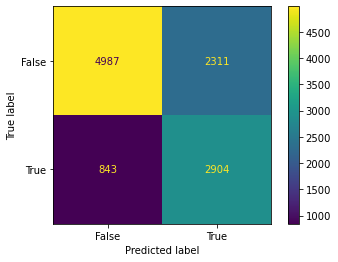

In [310]:
X, y, category_names = generate_labels(transcript,portfolio,profile)
y = y.viewed_completed
category_names = ['completed', 'not completed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

exploratory_training(X_train, X_test, y_train, y_test, category_names)

The performance with an F1-score of 0.77 for completed and 0.66 for not completed looks quite okay given no feature engineering that takes historic user event data into account and no collaborative information. 

Now we can have a look if we are able to predict offers that we do not want to sent out. There we have to consider that the classes are imbalanced. There are a lot less completed_but_no_view cases than other. To deal with the class imbalanced we use the balanced option of the classifier that  automatically adjust weights inversely proportional to class frequencies.

C:\Users\patri\AppData\Local\Temp/ipykernel_107564/3004380015.py:21: FutureWarning: inplace is deprecated and will be removed in a future version.
  label_data.index.set_levels(label_data.index.levels[2]+1,level=2, inplace=True)


Accuracy Score:0.7402444545043005
                       precision    recall  f1-score   support

completed_but_no_view       0.99      0.73      0.84     10151
                other       0.22      0.89      0.36       894

             accuracy                           0.74     11045
            macro avg       0.61      0.81      0.60     11045
         weighted avg       0.93      0.74      0.80     11045



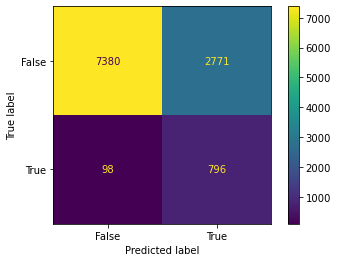

In [311]:
X, y, category_names = generate_labels(transcript,portfolio,profile)
y = y.not_viewed_completed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

category_names = ['completed_but_no_view', 'other']
exploratory_training(X_train, X_test, y_train, y_test, category_names)

### Collaborative prediction
In order to make use of the information of other users we use an collaborative approach using FunkSvd.

In [366]:
def funkSVD(ratings_mat, latent_features=12, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    ratings_mat - (numpy array) a matrix with users as rows, movies as columns, and ratings as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    movie_mat - (numpy array) a latent feature by movie matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = ratings_mat.shape[0]
    n_movies = ratings_mat.shape[1]
    num_ratings = np.count_nonzero(~np.isnan(ratings_mat))
    
    # initialize the user and movie matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_movies)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # keep track of iteration and MSE
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    ratings_matrix = ratings_mat.to_numpy()
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-movie pair
        for i in range(n_users):
            for j in range(n_movies):
                
                # if the rating exists
                if ~np.isnan(ratings_matrix[i, j]):
                    
                    # compute the error as the actual minus the dot product of the user and movie latent features
                    diff = ratings_matrix[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_ratings))
        
    return pd.DataFrame(user_mat,index=user_offer_matrix.index.get_level_values(0)),\
        pd.DataFrame(offer_mat,columns=user_offer_matrix.columns.get_level_values(1)) 

def funkSVD_predict_rating(user_matrix, offer_matrix, user_id, offer_id):
    '''
    INPUT:
    user_matrix - user by latent factor matrix
    offer_matrix - latent factor by offer matrix
    user_id - the user_id from the reviews df
    offer_id - the offer_id according the offer df
    
    OUTPUT:
    pred - the predicted rating for user_id-offer_id according to FunkSVD
    '''
    # Use the training data to create a series of users and offer that matches the ordering in training data
    # User row and offer Column
    
    user_factors = user_matrix.loc[user_id]
    offer_factors = offer_matrix[offer_id]
    # Take dot product of that row and column in U and V to make prediction
    pred = np.dot(user_factors,offer_factors)
    return pred

def funkSVD_predict_batch(X, user_mat, offer_mat,threshold_values=True):
    user_offer_pairs = X[['user_id','offer']].copy()
    predictions = []
    
    for i, row in user_offer_pairs.iterrows():
        try:
            predictions.append(funkSVD_predict_rating(user_mat, offer_mat,row[0], row[1]))
        except:
            predictions.append(-1)
    pred = pd.DataFrame(predictions,columns=["viewed_completed"])
    # in order to make a classify we have to treshold the values and decide what to do with non predictions
    # for now we do not consider the non predicitons and make them zero
    if threshold_values:
        pred = pred.where(pred > 0.5,False).where(pred < 0.5,True).astype(bool)
    return pred


In [864]:
X, y, category_names = generate_labels(transcript,portfolio,profile)
y = y.viewed_completed
X.reset_index(drop=True,inplace=True)
y.reset_index(drop=True,inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 42)

svd_train_data = X_train.join(y_train)[['user_id','offer', 'viewed_completed']]
user_offer_matrix = svd_train_data.groupby(['user_id','offer']).any().unstack().replace(True, 1).replace(False, 0)
user_offer_matrix.iloc[4,1]
user_mat, offer_mat = funkSVD(user_offer_matrix, latent_features=11, learning_rate=0.015, iters=50)

C:\Users\patri\AppData\Local\Temp/ipykernel_107564/3004380015.py:21: FutureWarning: inplace is deprecated and will be removed in a future version.
  label_data.index.set_levels(label_data.index.levels[2]+1,level=2, inplace=True)


Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.206165
2 		 0.193766
3 		 0.192264
4 		 0.190732
5 		 0.189163
6 		 0.187549
7 		 0.185883
8 		 0.184153
9 		 0.182349
10 		 0.180459
11 		 0.178467
12 		 0.176360
13 		 0.174120
14 		 0.171729
15 		 0.169170
16 		 0.166425
17 		 0.163477
18 		 0.160311
19 		 0.156915
20 		 0.153282
21 		 0.149409
22 		 0.145300
23 		 0.140967
24 		 0.136429
25 		 0.131710
26 		 0.126843
27 		 0.121864
28 		 0.116810
29 		 0.111723
30 		 0.106642
31 		 0.101603
32 		 0.096641
33 		 0.091785
34 		 0.087059
35 		 0.082484
36 		 0.078075
37 		 0.073842
38 		 0.069793
39 		 0.065932
40 		 0.062260
41 		 0.058775
42 		 0.055474
43 		 0.052353
44 		 0.049405
45 		 0.046625
46 		 0.044005
47 		 0.041538
48 		 0.039217
49 		 0.037034
50 		 0.034982


Accuracy Score:1.0
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     29118
        True       1.00      1.00      1.00     15059

    accuracy                           1.00     44177
   macro avg       1.00      1.00      1.00     44177
weighted avg       1.00      1.00      1.00     44177



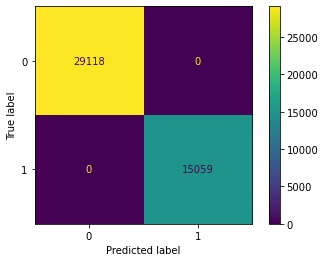

In [861]:
y_train_svd_pred = funkSVD_predict_batch(X_train, user_mat, offer_mat,threshold_values=True)
print("Accuracy Score:" + str(accuracy_score(y_train, y_train_svd_pred)))
print(classification_report(y_train_svd_pred, y_train))
cm = confusion_matrix(y_train_svd_pred, y_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()

We are completely fitting the training set which is expected doing any kind of SVD. Let´s have a look at our test performance:

Accuracy Score:0.6674513354459031
              precision    recall  f1-score   support

       False       0.74      0.75      0.74      7063
        True       0.54      0.52      0.53      3982

    accuracy                           0.67     11045
   macro avg       0.64      0.64      0.64     11045
weighted avg       0.67      0.67      0.67     11045



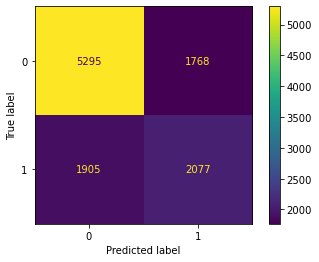

In [862]:
y_test_svd_pred = funkSVD_predict_batch(X_test, user_mat, offer_mat,threshold_values=True)
print("Accuracy Score:" + str(accuracy_score(y_test, y_test_svd_pred)))
print(classification_report(y_test_svd_pred, y_test))
cm = confusion_matrix(y_test_svd_pred, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()

The collaborative aproach has lower performance then the classifier. It seems that the class separability in general is worse and on a quite low level. Still we are a bit better than rolling a dice.

Accuracy Score:0.6688999547306473
               precision    recall  f1-score   support

    completed       0.75      0.74      0.74      7200
not completed       0.52      0.54      0.53      3845

     accuracy                           0.67     11045
    macro avg       0.64      0.64      0.64     11045
 weighted avg       0.67      0.67      0.67     11045



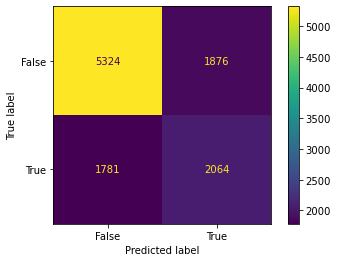

In [857]:
X_test_svd = X_test.join(funkSVD_predict_batch(X_test, user_mat, offer_mat,threshold_values=False))
X_train_svd = X_train.join(funkSVD_predict_batch(X_train, user_mat, offer_mat,threshold_values=False))

category_names = ['completed', 'not completed']
exploratory_training(X_train_svd, X_test_svd, y_train, y_test, category_names)



              precision    recall  f1-score   support

       False       0.68      0.65      0.67      7524
        True       0.32      0.35      0.34      3521

    accuracy                           0.56     11045
   macro avg       0.50      0.50      0.50     11045
weighted avg       0.57      0.56      0.56     11045

              precision    recall  f1-score   support

       False       0.68      0.66      0.67     30134
        True       0.32      0.34      0.33     14043

    accuracy                           0.56     44177
   macro avg       0.50      0.50      0.50     44177
weighted avg       0.57      0.56      0.56     44177



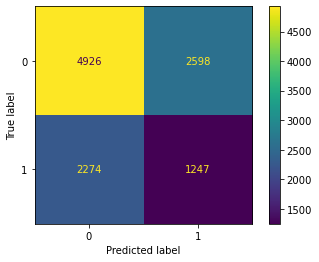

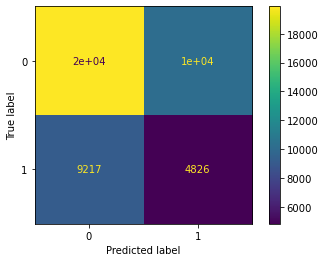

In [738]:
print(classification_report(y_test_svd_pred, y_test))
cm = confusion_matrix(y_test_svd_pred, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print(classification_report(y_train_svd_pred, y_train))
cm = confusion_matrix(y_train_svd_pred, y_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()

Accuracy Score:0.7221367134449977
               precision    recall  f1-score   support

    completed       0.86      0.68      0.76      7200
not completed       0.57      0.80      0.67      3845

     accuracy                           0.72     11045
    macro avg       0.72      0.74      0.71     11045
 weighted avg       0.76      0.72      0.73     11045



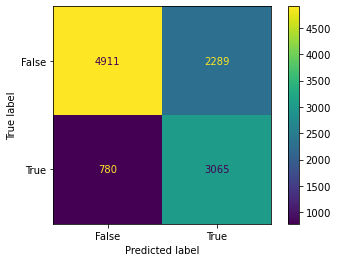

In [649]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
X_test_svd = X_test.join(funkSVD_predict_batch(X_test, user_mat, offer_mat,threshold_values=False))
X_train_svd = X_train.join(funkSVD_predict_batch(X_train, user_mat, offer_mat,threshold_values=False))

#print(classification_report(X_test_svd, y_test))
#cm = confusion_matrix(X_test_svd, y_test)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()

category_names = ['completed', 'not completed']
exploratory_training(X_train_svd, X_test_svd, y_train, y_test, category_names)

              precision    recall  f1-score   support

       False       0.69      0.65      0.67      7641
        True       0.31      0.34      0.32      3404

    accuracy                           0.56     11045
   macro avg       0.50      0.50      0.50     11045
weighted avg       0.57      0.56      0.56     11045



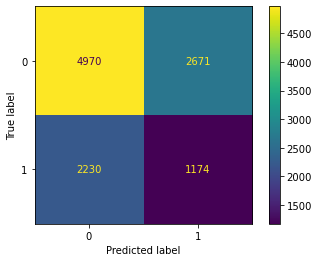

In [646]:

print(classification_report(X_test_svd.viewed_completed, y_test))
cm = confusion_matrix(X_test_svd.viewed_completed, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()

## Takeaways

- a big challenge was to understand the experiment itself. Most of the informations about the experiment had to be reverse engineered from the data. Only with understanding the experiment it was possible to figure out what business value we can generate from the data.